### Read in overlaid data

In [1]:
import pandas as pd
df = pd.read_parquet('./material/soc.snr_overlaid_v20250301.pq')
print(df.shape)

(122436, 468)


### Mask out other land covers

In [2]:
nan_stats = df.groupby('ref')['lc_survey'].agg(
    total_count='count',
    nan_count=lambda x: x.isna().sum(),
    total_rows=lambda x: x.shape[0]
)

nan_stats['nan_percentage'] = 100 * nan_stats['nan_count'] / nan_stats['total_rows']
print(nan_stats)
keep_ref = nan_stats.loc[nan_stats['nan_percentage']<10].index.tolist()

                total_count  nan_count  total_rows  nan_percentage
ref                                                               
Czech                   728          0         728        0.000000
GLanCE                  911          0         911        0.000000
LUCAS                 62577          1       62578        0.001598
MarSOC                  103          0         103        0.000000
NatbodDS                  0       4813        4813      100.000000
ParcelasCOS            1578          0        1578        0.000000
ParcelasINES          22161          0       22161        0.000000
Pedološka               217          8         225        3.555556
SoDaH                    72        303         375       80.800000
basque                  826          0         826        0.000000
dk.pilot                131          0         131        0.000000
estonia.kese              0        172         172      100.000000
foregs                    0        248         248      100.00

In [5]:
df = df.loc[df['ref'].isin(keep_ref)]
print(df.shape)
df = df.loc[df['lc_survey'].notna()]
print(df.shape)
# remove MarSOC and DK pilot points
df = df.loc[df['ref']!='ukceh']
print(df.shape)
df = df.loc[df['ref']!='dk.pilot']
print(df.shape)
print(df['ref'].unique().tolist())

(112435, 468)
(112426, 468)
(109675, 468)
(109544, 468)
['GLanCE', 'Pedološka', 'Czech', 'basque', 'ParcelasINES', 'MarSOC', 'gemas', 'LUCAS', 'thuenen.bze.lw', 'ParcelasCOS']


## organize covariate data

In [6]:
fix_col = []
covs = df.columns[64::].tolist()
for icov in covs:
    inum = df[icov].isna().sum()
    irto = round(inum/len(df),3)
    
    if irto>0.02:
        print(icov, irto, df[icov].min(), df[icov].max())
        fix_col.append(icov)

cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604 0.598 25.0 100.0
b3_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 104.0 6050.0
CHELSA_swe_1981-2010_V.2.1 0.665 35.0 28517.0
b12_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 43.0 6815.0
b6_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 51.0 7486.0
b4_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 119.0 6890.0
b2_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 57.0 5343.0
b8_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 45.0 7494.0
b11_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 65.0 8015.0
b7_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 54.0 7562.0
b5_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 157.0 7170.0
b8a_soilsuite_m_30m_s_20180101_20221231_eu_epsg.3035_v20250307 0.57 39.0 7857.0


In [7]:
fl = 'cropland.extent_glad.interpolate_p_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240604'
df.loc[df[fl].isna(),fl] = 0
df.loc[df[fl]>0,fl] = 100
fix_col.remove(fl)

fl = 'CHELSA_swe_1981-2010_V.2.1'
df = df.drop(columns=[fl])
fix_col.remove(fl)
covs.remove(fl)

for fl in fix_col:
    df.loc[df[fl].isna(),fl] = 0


In [8]:
for icov in covs:
    inum = df[icov].isna().sum()
    irto = round(inum/len(df),3)
    
    if irto>0.02:
        print(icov, irto, df[icov].min(), df[icov].max())

## Harmonize soc measurements to be topsoil

In [9]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from skmap.misc import TimeTracker, ttprint

single_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) == 1)
single_records = single_depth_groups[single_depth_groups['hzn_dep'] <= 20].copy()
single_records['type'] = 'measured'
print("keep single-depth records with hzn_dep <= 20 cm, ", single_records.shape)

multi_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) > 1)
multi_with_10 = multi_depth_groups[multi_depth_groups['hzn_dep'] == 10]
multi_records_10 = multi_with_10.copy()  
multi_records_10['type'] = 'measured'
print("Keep multi-depth records where hzn_dep = 10:", multi_records_10.shape)

multi_depth_interpolate = multi_depth_groups.groupby(['lat', 'lon', 'time']).filter(lambda g: not (g['hzn_dep'] == 10).any())
print("multi-depth group needs interpolation count:", multi_depth_interpolate.shape)

itpl_records = []
for (lat, lon, time), group in multi_depth_interpolate.groupby(['lat', 'lon', 'time']):
    group = group.sort_values(by='hzn_dep').drop_duplicates(subset=['hzn_dep'])
    new_record = group.iloc[0].copy()  # keep all other columns
    for prop in ['soc','total.n','clay','ph.h2o','ph.cacl2']:
        try:
            # cs = CubicSpline(group['hzn_dep'], group[prop])
            pc = PchipInterpolator(group['hzn_dep'], group[prop])
            new_record[prop] = pc(10).item()  # interpolte
        except Exception as e:
            new_record[prop] = np.nan
            # print(f"Interpolation error at ({group['lat'].iloc[0]}, {group['lon'].iloc[0]}, {group['time'].iloc[0]}): {e}")
    new_record['hzn_dep'] = 10  # same as standard LUCAS depth
    itpl_records.append(new_record)
    
interpolated_records = pd.DataFrame(itpl_records)
interpolated_records['type'] = 'interpolated'
print("Interpolating hzn_dep==10cm for multi-depth groups,", interpolated_records.shape)

dff = pd.concat([single_records, multi_records_10, interpolated_records], ignore_index=True)
print("topsoil harmonized, ", dff.shape)


keep single-depth records with hzn_dep <= 20 cm,  (89539, 468)
Keep multi-depth records where hzn_dep = 10: (643, 468)
multi-depth group needs interpolation count: (18714, 467)
Interpolating hzn_dep==10cm for multi-depth groups, (4073, 468)
topsoil harmonized,  (94255, 468)


## Apply different masks

In [10]:
tgt = 'soc'
dff = dff.dropna(subset=covs+[tgt],how='any')
# ttest = dff.loc[dff['ref']=='LUCAS'].sample(3000)
ttid = pd.read_csv('./material/test_temporal_ids.txt', header=None)[0].tolist() 
ttid = [str(ii) for ii in ttid]
ttest = dff.loc[dff['id'].isin(ttid)]
print(ttest.shape)
df0 = dff.loc[~dff['id'].isin(ttid)]
print(dff.shape)

(2350, 468)
(92103, 468)


In [11]:
dff['soilsuite_mask'].unique()

array([1., 2., 3.], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split

### scenarios
df1 = df0.loc[df0['soilsuite_mask']==1]
df2 = df0.loc[df0['soilsuite_mask']==2]
df3 = df0.loc[df0['soilsuite_mask'].isin([1,2])]
df4 = df0.loc[~df0['soilsuite_mask'].isin([1,2])]

train0, test0 = train_test_split(df0, test_size=0.33, random_state=42)
train1, test1 = train_test_split(df1, test_size=0.33, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.33, random_state=42)
train3, test3 = train_test_split(df3, test_size=0.33, random_state=42)
train4, test4 = train_test_split(df4, test_size=0.33, random_state=42)

[15:43:46] start training
[15:45:03] start predicting


/tmp/ipykernel_2321987/2435201015.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


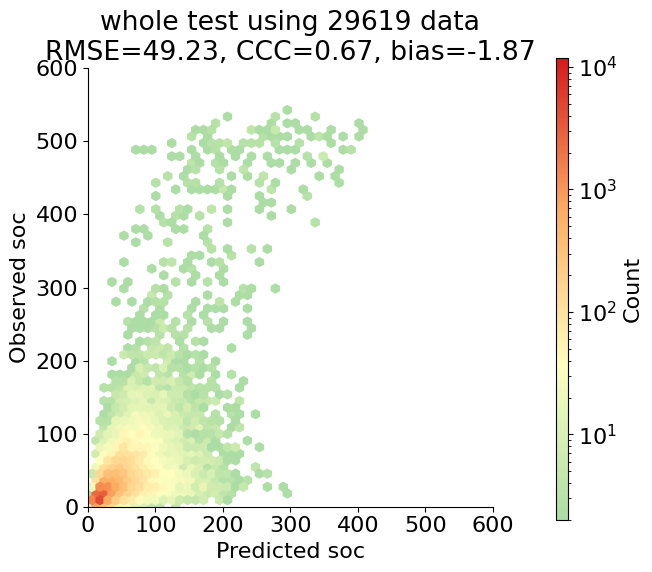

/tmp/ipykernel_2321987/2435201015.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


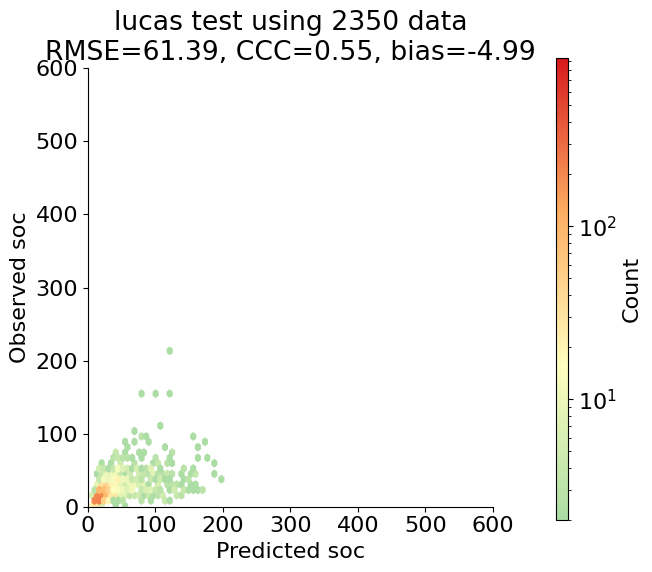

[15:45:04] start training
[15:45:35] start predicting


/tmp/ipykernel_2321987/2435201015.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


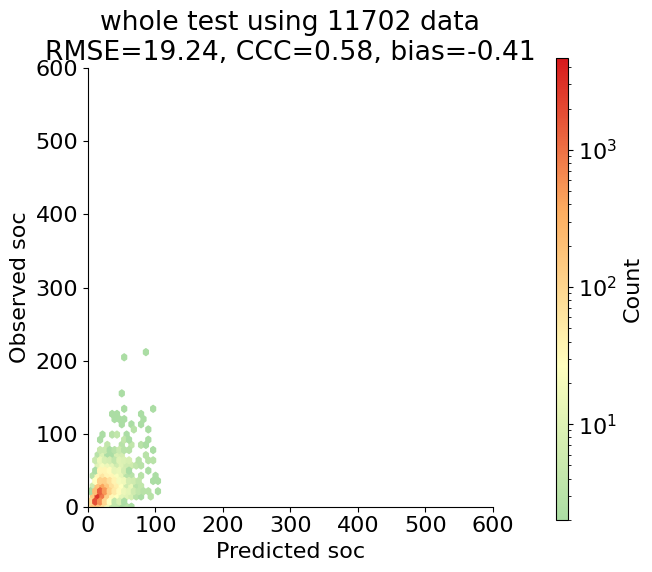

/tmp/ipykernel_2321987/2435201015.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


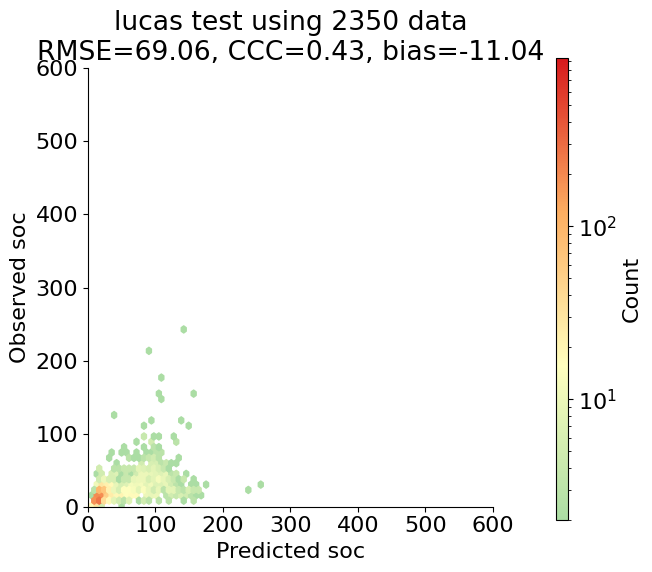

[15:45:36] start training
[15:46:15] start predicting


/tmp/ipykernel_2321987/2435201015.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


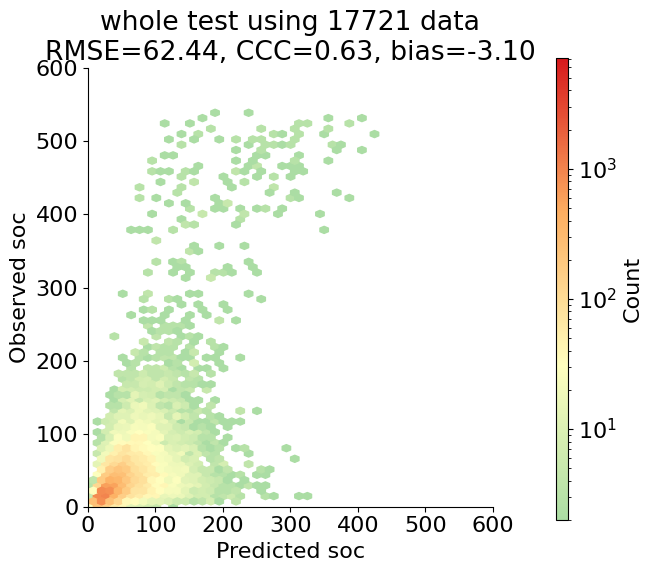

/tmp/ipykernel_2321987/2435201015.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


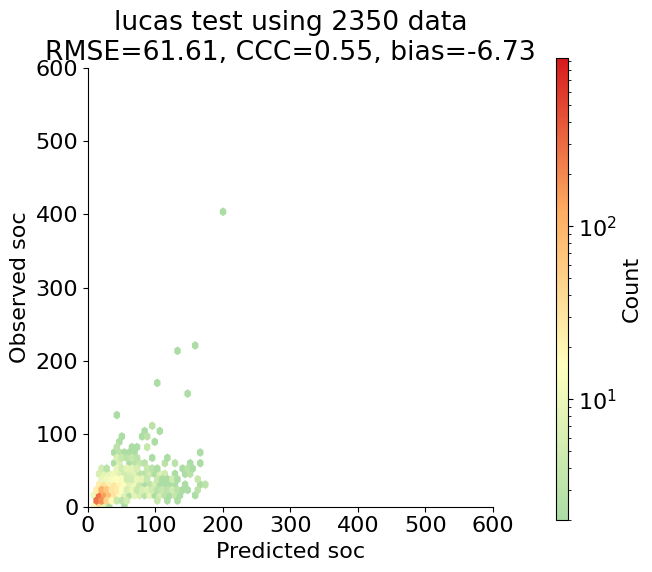

[15:46:16] start training
[15:47:27] start predicting


/tmp/ipykernel_2321987/2435201015.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


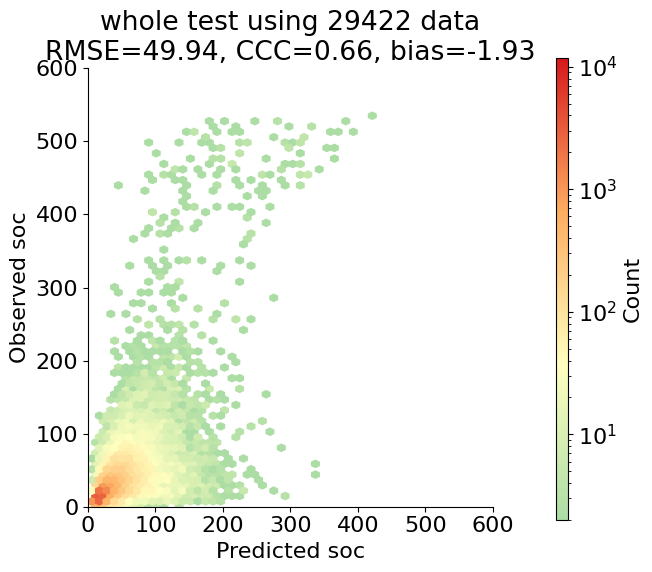

/tmp/ipykernel_2321987/2435201015.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


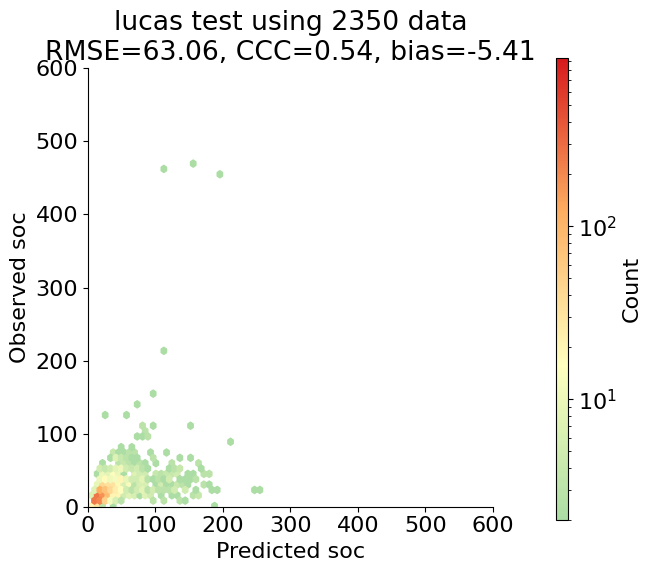

[15:47:28] start training
[15:47:28] start predicting


/tmp/ipykernel_2321987/2435201015.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


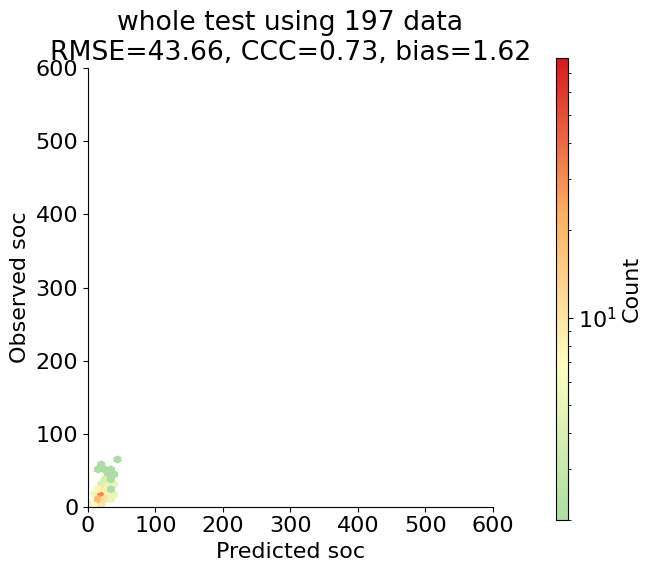

/tmp/ipykernel_2321987/2435201015.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


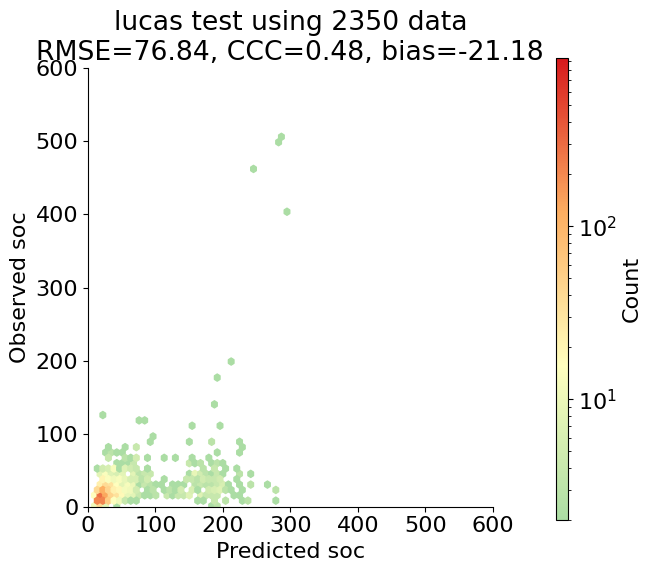

In [13]:
from sklearn.ensemble import RandomForestRegressor
from model_fit import calc_metrics
import math
import numpy as np
import matplotlib.pyplot as plt
from skmap.misc import find_files, GoogleSheet, ttprint
from matplotlib.colors import LinearSegmentedColormap

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
trainl = [train0, train1, train2, train3, train4]
testl = [test0, test1, test2, test3, test4]
snrl = ['all', 'only bare', 'only permanent', 'both vege and bare', 'only other lc']

metricl = []
for ii in [0,1,2,3,4]:
    ttprint('start training')
    rf.fit(trainl[ii][covs], trainl[ii][tgt])
    
    ttprint('start predicting')
    y_pred = rf.predict(testl[ii][covs])
    y_test = testl[ii][tgt]
    rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'normal')
    metricl.append([snrl[ii], 'whole_test', rmse, mae, medae, mape, ccc, r2, bias])
    vmax = 0.4 * len(y_test)
    
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(f'whole test using {len(testl[ii])} data\nRMSE={rmse:.2f}, CCC={ccc:.2f}, bias={bias:.2f}')
    hb = ax.hexbin(y_pred, y_test, gridsize=(40, 40), cmap=cet_l19_cmap, mincnt=2, vmax=vmax, bins='log')
    ax.set_xlabel(f'Predicted soc')
    ax.set_ylabel(f'Observed soc')
    ax.set_aspect('auto', adjustable='box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0,600])
    ax.set_ylim([0,600])
    # ax.plot(show_range, show_range, "-k", alpha=.5)
    cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    cb = fig.colorbar(hb, cax=cax)
    cb.set_label('Count')
    plt.tight_layout(rect=[0, 0, 0.92, 1])  
    plt.show()
    
    y_pred = rf.predict(ttest[covs])
    y_test = ttest[tgt]
    rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'normal')
    metricl.append([snrl[ii], 'lucas_test', rmse, mae, medae, mape, ccc, r2, bias])
    vmax = 0.4 * len(y_test)
    
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(f'lucas test using {len(ttest)} data\nRMSE={rmse:.2f}, CCC={ccc:.2f}, bias={bias:.2f}')
    hb = ax.hexbin(y_pred, y_test, gridsize=(40, 40), cmap=cet_l19_cmap, mincnt=2, vmax=vmax, bins='log')
    ax.set_xlabel(f'Predicted soc')
    ax.set_ylabel(f'Observed soc')
    ax.set_aspect('auto', adjustable='box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0,600])
    ax.set_ylim([0,600])
    # ax.plot(show_range, show_range, "-k", alpha=.5)
    cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    cb = fig.colorbar(hb, cax=cax)
    cb.set_label('Count')
    plt.tight_layout(rect=[0, 0, 0.92, 1])  
    plt.show()

In [14]:
mdf = pd.DataFrame(metricl, columns=['scenario','test type','rmse', 'mae', 'medae', 'mape', 'ccc', 'r2', 'bias'])

In [15]:
mdf.loc[mdf['test type']=='lucas_test']


,scenario,test type,rmse,mae,medae,mape,ccc,r2,bias
1,all,lucas_test,61.393808,28.715530,7.971766,0.459844,0.554584,-0.528816,-4.992831
3,only bare,lucas_test,69.063619,35.931651,10.523504,0.509404,0.430629,-1.088730,-11.038210
5,only permanent,lucas_test,61.607911,29.764598,9.901617,0.490340,0.548323,-0.590727,-6.732227
7,both vege and bare,lucas_test,63.056745,29.395595,7.939373,0.460995,0.538276,-0.523148,-5.405874
9,only other lc,lucas_test,76.838942,41.429542,12.281720,0.542047,0.481329,-0.189672,-21.177259


In [16]:
mdf.loc[mdf['test type']=='whole_test']


,scenario,test type,rmse,mae,medae,mape,ccc,r2,bias
0,all,whole_test,49.232628,23.530488,8.836017,0.453243,0.673018,-0.056958,-1.867943
2,only bare,whole_test,19.244472,7.952036,3.895538,0.356251,0.584810,-0.681163,-0.414254
4,only permanent,whole_test,62.439504,34.142246,15.781000,0.513596,0.630705,-0.266943,-3.100721
6,both vege and bare,whole_test,49.942841,23.570198,8.807751,0.454294,0.657233,-0.103280,-1.929838
8,only other lc,whole_test,43.663273,19.528164,8.011150,0.523754,0.732350,0.042590,1.617152


## conclusion: using all points scenarios seems to be the best